<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Trials

* use single or multiple optimization goals



In [321]:
!pip install -q --upgrade optuna >/dev/null

In [322]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt

## Connect Google Drive

In [323]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Database Connection

In [324]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Show all Studies

In [325]:
for s in optuna.get_all_study_summaries(storage):
    start = "???" if s.datetime_start is None else s.datetime_start.date()
    print(f"{str(start):>10} {s.n_trials:>4} trials '{s.study_name}'")

2021-12-18  220 trials 'distilbert-base-german-cased'
2021-12-18   70 trials 'distilbert-base-german-cased_bs32'
2021-12-20  171 trials 'distilbert-base-german-cased_multi_mcc'
2021-12-21   52 trials 'distilbert-base-german-cased_multi_epoch234'
2021-12-21  103 trials 'distilbert-base-german-cased_epoch2'
2021-12-22   93 trials 'deepset/gbert-base_epoch2_bs16'
2021-12-23   29 trials 'deepset/gbert-base_bs16_epoch234'
2021-12-27  133 trials 'deepset/gbert-base_loss-mcc_bs16_epoch234'
2021-12-30   69 trials 'deepset/gelectra-base_loss-mcc_bs16_epoch234'
2022-01-01   16 trials 'deepset/gelectra-base_loss-f1_bs16_epoch234'


In [326]:
states = []
for s in optuna.get_all_study_summaries(storage):
    name = s.study_name
    study = optuna.load_study(name, storage)
    trial_states = [t.state for t in study.get_trials()]
    states.append(pd.Series(trial_states).value_counts().to_frame(name).T)

pd.concat(states).fillna(0).astype(int).reset_index()

,index,TrialState.COMPLETE,TrialState.RUNNING,TrialState.FAIL,TrialState.PRUNED
0,distilbert-base-german-cased,212,4,4,0
1,distilbert-base-german-cased_bs32,70,0,0,0
2,distilbert-base-german-cased_multi_mcc,170,0,1,0
3,distilbert-base-german-cased_multi_epoch234,50,2,0,0
4,distilbert-base-german-cased_epoch2,100,0,3,0
5,deepset/gbert-base_epoch2_bs16,86,5,2,0
6,deepset/gbert-base_bs16_epoch234,22,3,1,3
7,deepset/gbert-base_loss-mcc_bs16_epoch234,124,6,3,0
8,deepset/gelectra-base_loss-mcc_bs16_epoch234,64,3,2,0
9,deepset/gelectra-base_loss-f1_bs16_epoch234,15,1,0,0


In [327]:
study = optuna.load_study('deepset/gbert-base_loss-mcc_bs16_epoch234', storage)
best = study.best_trials[0]
best.intermediate_values

{}

## Show Best Results of Studies

In [328]:
# get longest study name for formatting
maxlen = max([len(s.study_name) for s in optuna.get_all_study_summaries(storage)])

for s in optuna.get_all_study_summaries(storage):
    study = optuna.load_study(s.study_name, storage)
    for i, t in enumerate(study.best_trials):
        values = [f"{val:.4}" for val in t.values]
        attrs = t.user_attrs
        if "eval_result" in attrs.keys():
            attrs = attrs["eval_result"]
        print(f"{s.study_name:<{maxlen}} (#{i+1}) {t.number:>3}: {', '.join([f'{k[5:]}={attrs[k]:.4}' for k in [*attrs]])}")

distilbert-base-german-cased                 (#1) 134: acc=0.8745, f1=0.8724, loss=0.37, precision=0.8718, recall=0.8738, runtime=10.36, samples_per_second=99.21, steps_per_second=6.273
distilbert-base-german-cased_bs32            (#1)  67: acc=0.8804, f1=0.8792, loss=0.3715, precision=0.8807, recall=0.8782, runtime=9.57, samples_per_second=107.4, steps_per_second=3.448
distilbert-base-german-cased_multi_mcc       (#1)   1: acc=0.8833, f1=0.8825, loss=0.3724, mcc=0.8663, precision=0.8818, recall=0.8836, runtime=9.964, samples_per_second=103.2, steps_per_second=6.524
distilbert-base-german-cased_multi_mcc       (#2)  27: acc=0.8774, f1=0.8761, loss=0.37, mcc=0.8596, precision=0.8769, recall=0.8759, runtime=9.655, samples_per_second=106.5, steps_per_second=3.418
distilbert-base-german-cased_multi_mcc       (#3) 114: acc=0.8774, f1=0.8761, loss=0.37, mcc=0.8596, precision=0.8769, recall=0.8759, runtime=9.528, samples_per_second=107.9, steps_per_second=3.463
distilbert-base-german-cased_mu

In [329]:
[s.study_name for s in optuna.get_all_study_summaries(storage)]

['distilbert-base-german-cased',
 'distilbert-base-german-cased_bs32',
 'distilbert-base-german-cased_multi_mcc',
 'distilbert-base-german-cased_multi_epoch234',
 'distilbert-base-german-cased_epoch2',
 'deepset/gbert-base_epoch2_bs16',
 'deepset/gbert-base_bs16_epoch234',
 'deepset/gbert-base_loss-mcc_bs16_epoch234',
 'deepset/gelectra-base_loss-mcc_bs16_epoch234',
 'deepset/gelectra-base_loss-f1_bs16_epoch234']

In [330]:
# optuna.delete_study('deepset/gelectra-base_loss-f1_bs16_epoch234', storage)

In [331]:
print(study.study_name)
if len(study.best_trials) > 0:
    display(study.best_trials[0].distributions)

deepset/gelectra-base_loss-f1_bs16_epoch234


{'learning_rate': LogUniformDistribution(high=0.0002, low=6e-05),
 'num_train_epochs': CategoricalDistribution(choices=(2, 3)),
 'per_device_train_batch_size': CategoricalDistribution(choices=(16,)),
 'weight_decay': LogUniformDistribution(high=0.01, low=0.001)}

## Load Study

In [332]:
# study = optuna.load_study('distilbert-base-german-cased_epoch2', storage)
# study = optuna.load_study('distilbert-base-german-cased_multi_epoch234', storage)
# study = optuna.load_study('deepset/gbert-base_loss-mcc_bs16_epoch234', storage)
# study = optuna.load_study('deepset/gelectra-base_loss-mcc_bs16_epoch234', storage)
study = optuna.load_study('deepset/gelectra-base_loss-f1_bs16_epoch234', storage)

In [333]:
# study.get_trials()

## Analyze Complete Trials

In [334]:
from optuna.trial import TrialState

complete_trials = [t for t in study.get_trials() if t.state==TrialState.COMPLETE]

In [335]:
def get_metrics(trial):
    attrs = trial.user_attrs
    if "eval_result" in attrs.keys():
        attrs = attrs["eval_result"]
    return attrs

# create DataFrames
if len(complete_trials) > 0:
    index = [t.number for t in complete_trials]
    trial_metrics_df = pd.DataFrame([get_metrics(t) for t in complete_trials], index=index)
    trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
    trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss", ascending=True)
    best = [t.number for t in study.best_trials]
    trial_df["best"] = trial_df.index.isin(best)
    trial_params_df["eval_loss"] = trial_metrics_df["eval_loss"]
    display(trial_df.head(10))

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,best
11,0.000064,2,16,0.003230,0.385312,0.898833,0.897088,0.895333,0.899887,0.884294,19.3585,53.103,3.358,2.0,True
7,0.000102,2,16,0.001227,0.386954,0.894942,0.890006,0.889330,0.891432,0.879744,19.5534,52.574,3.324,2.0,False
4,0.000118,3,16,0.002158,0.394007,0.897860,0.894021,0.892969,0.895307,0.883030,19.4944,52.733,3.334,3.0,False
8,0.000090,2,16,0.001609,0.396568,0.892023,0.892059,0.891308,0.894298,0.876494,19.5166,52.673,3.331,2.0,False
3,0.000069,3,16,0.006160,0.396954,0.898833,0.896764,0.895507,0.898605,0.884143,19.4285,52.912,3.346,3.0,False
13,0.000062,2,16,0.005442,0.402812,0.892996,0.889122,0.888508,0.890664,0.877514,19.4110,52.960,3.349,2.0,False
10,0.000120,2,16,0.003205,0.411962,0.886187,0.881983,0.882014,0.882991,0.869690,19.3594,53.101,3.358,2.0,False
5,0.000087,3,16,0.002123,0.416407,0.890078,0.889863,0.894852,0.888325,0.874430,19.5044,52.706,3.333,3.0,False
2,0.000084,3,16,0.001118,0.416528,0.890078,0.888588,0.890402,0.887275,0.874042,19.3975,52.997,3.351,3.0,False
12,0.000109,3,16,0.002659,0.425757,0.895914,0.891628,0.895894,0.888113,0.880715,19.3998,52.990,3.351,3.0,False


In [336]:
import plotly.express as px

fig = px.parallel_coordinates(trial_df[trial_params_df.columns], color="eval_loss", 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.update_layout(autosize=False, width=700, height=350)
fig.show()

In [337]:
# fig = optuna.visualization.plot_parallel_coordinate(study, target=lambda trial: trial.user_attrs["eval_loss"], target_name="loss")
# fig.update_layout(autosize=False, width=700, height=350)
# fig.show()

In [338]:
# optuna.visualization.plot_contour(study)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



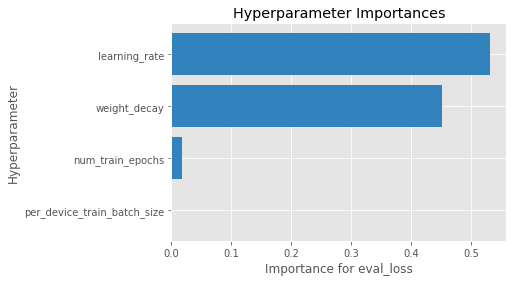

In [339]:
# from optuna.visualization import plot_param_importances
from optuna.visualization.matplotlib import plot_param_importances

fig = plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)
# fig.update_layout(autosize=False, width=800, height=350)
# fig.show()

In [340]:
def get_loss(trial):
    """Handle different data format versions"""
    if "eval_result" in trial.user_attrs.keys():
        return trial.user_attrs["eval_result"]["eval_loss"]
    else:
        return trial.user_attrs["eval_loss"]

In [341]:
fig = optuna.visualization.plot_slice(study, target=get_loss, target_name="loss")
fig.update_layout(autosize=False, width=900, height=350)
fig.show()

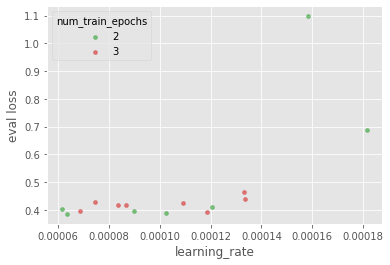

In [342]:
import seaborn as sns

pal = sns.color_palette("tab10", 10)

# plt.scatter(trial_df.eval_loss, trial_df.learning_rate, c=trial_df.best, cmap="Set1_r", alpha=0.6, s=8);
field = "num_train_epochs"
for f in sorted(trial_df[field].unique()):
    df = trial_df[lambda x: x[field] == f]
    plt.scatter(df.learning_rate, df.eval_loss, alpha=0.6, s=16, label=f, color=pal[f])

# plt.gca().set_xscale('log')
plt.legend(title=field)
plt.ylabel("eval loss")
plt.xlabel("learning_rate");

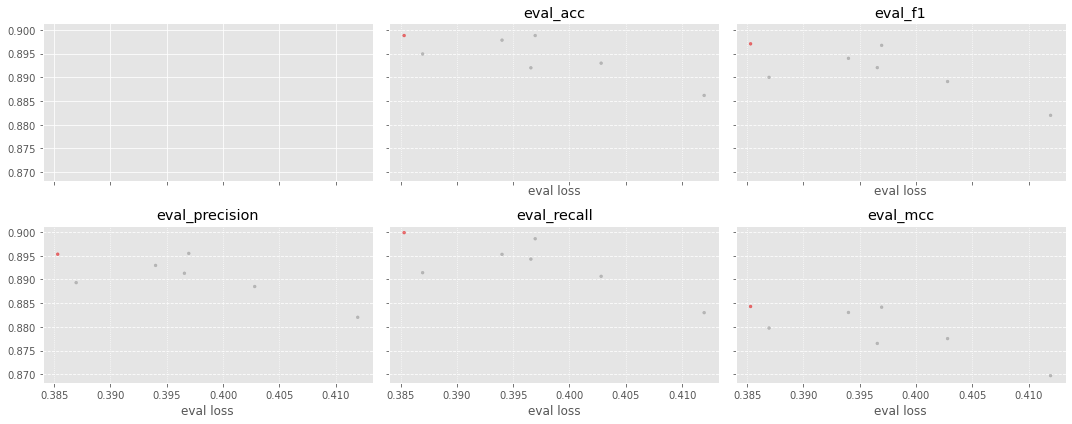

In [343]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
metrics = [m for m in trial_metrics_df.columns if m not in exclude]

# only focus on low loss trials
loss_df = trial_df[lambda x: x.eval_loss < x.eval_loss.median()]

for col, ax in zip(metrics, axs.flatten()):
    if col == "eval_loss":
        continue
    ax.scatter(loss_df.eval_loss, loss_df[col], c=loss_df.best, cmap="Set1_r", alpha=0.6, s=8);
    ax.set_title(col)
    ax.set_xlabel("eval loss")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

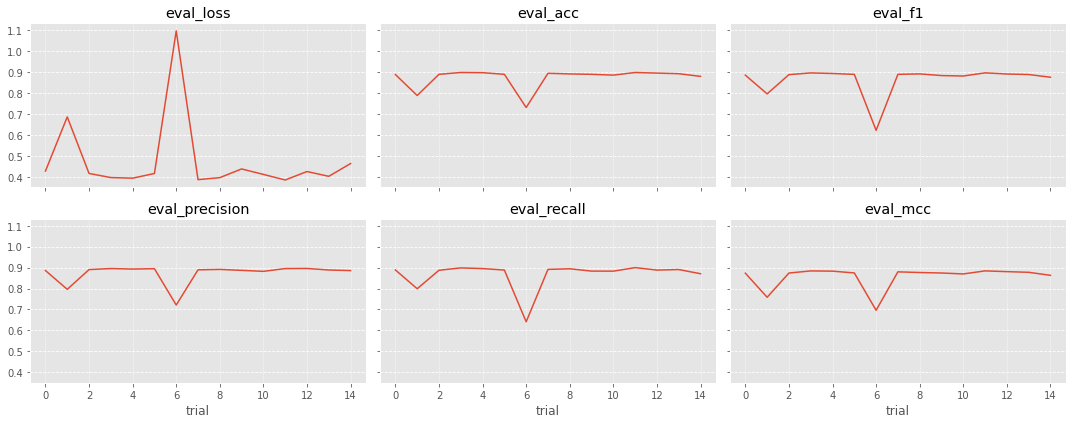

In [344]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

for col, ax in zip(metrics, axs.flatten()):
    trial_df[col].sort_index().plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel("trial")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

# Single Trial

In [345]:
running_trials = [t for t in study.get_trials() if t.state==TrialState.RUNNING]
data = complete_trials[-1].user_attrs
log_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
log_df.index = log_df.index.astype(int)
log_df.sort_index(inplace=True)
log_df

,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
115,1.522191,0.405642,0.356621,0.390500,0.382434,0.335771,19.3462,53.137,3.360,0.20
230,0.950073,0.672179,0.574745,0.604355,0.608544,0.636280,19.3744,53.060,3.355,0.40
345,0.896427,0.703307,0.625223,0.636685,0.661321,0.668811,19.3547,53.114,3.358,0.60
460,0.681159,0.810311,0.807030,0.812046,0.809215,0.783896,19.3590,53.102,3.358,0.80
575,0.656267,0.831712,0.814184,0.846252,0.801789,0.807845,19.3613,53.096,3.357,0.99
690,0.539133,0.860895,0.862653,0.872597,0.855489,0.840695,19.3757,53.056,3.355,1.19
805,0.553456,0.863813,0.860702,0.869853,0.856133,0.844350,19.4587,52.830,3.340,1.39
920,0.548706,0.849222,0.850105,0.857720,0.848903,0.828107,19.6102,52.422,3.315,1.59
1035,0.630055,0.849222,0.837250,0.864962,0.820615,0.827787,19.5728,52.522,3.321,1.79
1150,0.536451,0.857004,0.858861,0.861920,0.860820,0.837190,19.5903,52.475,3.318,1.99


In [346]:
log_df.index.max() / log_df.epoch.max()

578.0

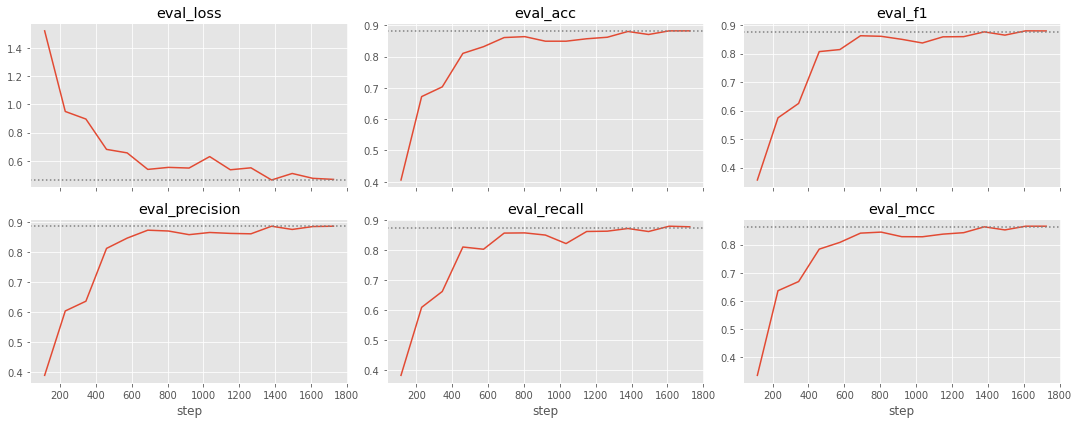

In [347]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True)

for col, ax in zip(metrics, axs.flatten()):
    log_df[col][0:-1].plot(ax=ax).axhline(log_df[col].values[-1], c="grey", linestyle=":")
    ax.set_title(col)
    ax.set_xlabel("step")
    # ax.set_xlim([600, None])
    # ax.grid(axis='y', linestyle='--', zorder=1)
    # ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

# Plot all Loss Curves

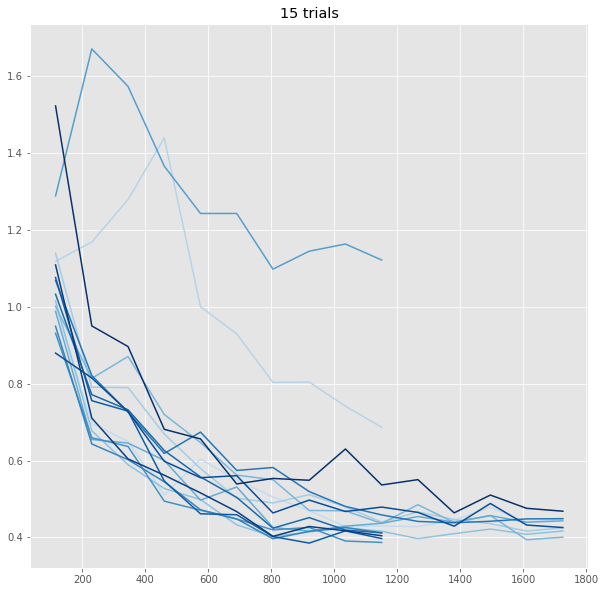

In [348]:
# https://stackoverflow.com/questions/52758070/color-map-to-shades-of-blue-python
# https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,10))

n = len(complete_trials)
colors = plt.cm.Blues(np.linspace(0.25,1,n))

count = 0
for i, t in enumerate(complete_trials):
    if not "eval_result" in t.user_attrs.keys():
        continue
    count += 1
    data = t.user_attrs
    loss_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    loss_df.index = loss_df.index.astype(int)
    loss_df.sort_index(inplace=True)
    ax.plot(loss_df["eval_loss"][0:-1], c=colors[i])
    # loss_df["eval_loss"].plot(ax=ax, cmap="Blues")
    # print(t.number, loss_df["eval_loss"])
plt.title(f"{count} trials");